In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
import lightkurve as lk
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS
import fitsio
from tqdm import tqdm

from astroquery.jplhorizons import Horizons

from tess_ephem import ephem, TessEphem, log
from tess_asteroid_ml import *
from ipywidgets import *
from sbident import SBIdent

In [2]:
path = "/Volumes/ADAP-Kepler/Work/BAERI/data/tess/ffi"
cutout_size = 50

In [3]:
def _load_ffi_image(
    telescope,
    fname,
    extension,
    cutout_size=None,
    cutout_origin=[0, 0],
    return_coords=False,
):
    """
    Use fitsio to load an image and return positions and flux values.
    It can do a smal cutout of size `cutout_size` with a defined origin.

    Parameters
    ----------
    telescope: str
        String for the telescope
    fname: str
        Path to the filename
    extension: int
        Extension to cut out of the image
    cutout_size : int
        Size of the cutout in pixels (e.g. 200)
    cutout_origin : tuple of ints
        Origin coordinates in pixels from where the cutout stars. Pattern is
        [row, column].
    return_coords : bool
        Return or not pixel coordinates.

    Return
    ------
    f: np.ndarray
        Array of flux values read from the file. Shape is [row, column].
    col_2d: np.ndarray
        Array of column values read from the file. Shape is [row, column]. Optional.
    row_2d: np.ndarray
        Array of row values read from the file. Shape is [row, column]. Optional.
    """
    f = fitsio.FITS(fname)[extension]
    if telescope.lower() == "kepler":
        # CCD overscan for Kepler
        r_min = 20
        r_max = 1044
        c_min = 12
        c_max = 1112
    elif telescope.lower() == "tess":
        # CCD overscan for TESS
        r_min = 0
        r_max = 2048
        c_min = 44
        c_max = 2092
    else:
        raise TypeError("File is not from Kepler or TESS mission")

    # If the image dimension is not the FFI shape, we change the r_max and c_max
    dims = f.get_dims()
    if dims == [r_max, c_max]:
        r_max, c_max = np.asarray(dims)
    r_min += cutout_origin[0]
    c_min += cutout_origin[1]
    if (r_min > r_max) | (c_min > c_max):
        raise ValueError("`cutout_origin` must be within the image.")
    if cutout_size is not None:
        r_max = np.min([r_min + cutout_size, r_max])
        c_max = np.min([c_min + cutout_size, c_max])
    if return_coords:
        row_2d, col_2d = np.mgrid[r_min:r_max, c_min:c_max]
        return col_2d, row_2d, f[r_min:r_max, c_min:c_max]
    return f[r_min:r_max, c_min:c_max]

In [4]:
sector = 4
camera = 1
ccd = 3
scc_str = f"s{sector:04}-{camera}-{ccd}"
scc_str

's0004-1-3'

In [5]:
def get_sector_dates(sector: int = 1):
    """
    Get sector observation dates (start, end) as a astropy Time object.
    """
    sector_date = pd.read_csv(
        f"{os.path.dirname(PACKAGEDIR)}/data/support/TESS_FFI_observation_times.csv"
    ).query(f"Sector == {sector}")
    if len(sector_date) == 0:
        raise ValueError(f"Sector {sector} not in data base.")

    return Time([sector_date.iloc[0]["Start Time"], sector_date.iloc[-1]["End Time"]], format='iso')

In [6]:
get_sector_dates(sector=sector)

<Time object: scale='utc' format='iso' value=['2018-10-19 09:59:39.000' '2018-11-14 07:59:38.000']>

In [7]:
ffi_path = f"{path}/sector{sector:04}/tess2018307065939-{scc_str}-0124-s_ffic.fits"

In [10]:
with fits.open(ffi_path) as ffi:
    wcs = WCS(ffi[1])
    date_obs = Time([ffi[0].header["DATE-OBS"], ffi[0].header["DATE-END"]])

Set MJD-END to 58425.317870 from DATE-END'. [astropy.wcs.wcs]


In [11]:
date_obs.mean().isot

'2018-11-03T07:22:43.951'

In [12]:
col_2d, row_2d, f2d = _load_ffi_image(
                "TESS",
                ffi_path,
                1,
                None,
                [0, 0],
                return_coords=True,
            )
ra_2d, dec_2d = wcs.all_pix2world(np.vstack([col_2d.ravel(), row_2d.ravel()]).T, 0.0).T
ra_2d = ra_2d.reshape(col_2d.shape)
dec_2d = dec_2d.reshape(col_2d.shape)

In [13]:
ffi_coord = SkyCoord(ra_2d*u.deg, dec_2d*u.deg, frame='icrs', obstime=date_obs.mean().isot)

In [14]:
print(ffi_coord.ra.min().hms, ffi_coord.ra.max().hms)
print(ffi_coord.dec.min().dms, ffi_coord.dec.max().dms)
print(ffi_coord.obstime.jd)

hms_tuple(h=2.0, m=33.0, s=9.823719075042874) hms_tuple(h=3.0, m=32.0, s=30.027709707358525)
dms_tuple(d=-2.0, m=-22.0, s=-17.35543243811641) dms_tuple(d=12.0, m=1.0, s=1.568711587250391)
2458425.8074531364


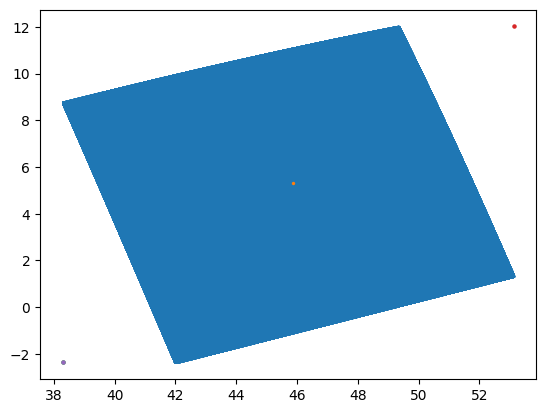

In [15]:
plt.scatter(ra_2d, dec_2d, s=1)
plt.scatter(ra_2d[1000, 1000], dec_2d[1000, 1000], s=2)
plt.scatter(ra_2d.min(), dec_2d.min(), s=5)
plt.scatter(ra_2d.max(), dec_2d.max(), s=5)
plt.scatter(ra_2d.min(), dec_2d.min(), s=5)
plt.show()

In [16]:
def query_jpl_sbi(edge1, edge2, obstime=2459490, maglim=22):
    print("Requesting JPL Smal-bodies API")
    
    #get state of TESS (-95) from Horizons at our observation time
    #and convert it from [AU, AU/day] to [km, km/s]
    # location 500 is geocentric, minor planet center.
    # 500@-95 means Geocentric location to TESS

    au = (1 * u.au).to(u.km).value #1AU in km
    tess = Horizons(id='-95', 
                    location='500', 
                    epochs=obstime, 
                    id_type=None
                   ).vectors(refplane='earth') #state vector
    tess_km = tess[['x','y','z',
                    'vx','vy','vz']].to_pandas().to_numpy() * au #convert to km/d
    tess_km[:,3:] = tess_km[:,3:] / 86400 #convert to km/s
    tess_km = tess_km[0] #take the first row

    #form the xobs dictionary that is the input for SBIdent location argument
    xobs = ','.join([np.format_float_scientific(s,precision=5) for s in tess_km])
    xobs_location = {'xobs': xobs}

    sbid3 = SBIdent(location=xobs_location, 
                    obstime=obstime, 
                    fov=[edge1, edge2], 
                    maglim=maglim, 
                    precision="high", 
                    request=True,
                   )

    jpl_sb = sbid3.results.to_pandas()
    
    # parse columns
    jpl_sb["Astrometric Dec (dd mm\'ss\")"] = [
        x.replace(" ",":").replace("\'",":").replace('"', "") 
        for x in jpl_sb["Astrometric Dec (dd mm\'ss\")"]
    ]
    coord = SkyCoord(jpl_sb[["Astrometric RA (hh:mm:ss)", 
                             "Astrometric Dec (dd mm\'ss\")"]].values, 
             frame='icrs', 
             unit=(u.hourangle, u.deg))
    jpl_sb["ra"] = coord.ra.deg
    jpl_sb["dec"] = coord.dec.deg
    jpl_sb["V_mag"] = jpl_sb["Visual magnitude (V)"].replace("n.a.", np.nan)
    jpl_sb["V_mag"] = [
        float(x) if not x.endswith("N") else float(x[:-1]) for x in jpl_sb["V_mag"]
    ]
    jpl_sb['RA rate ("/h)'] = jpl_sb['RA rate ("/h)'].astype(float)
    jpl_sb['Dec rate ("/h)'] = jpl_sb['Dec rate ("/h)'].astype(float)
    jpl_sb["name"] = jpl_sb["Object name"].apply(
        lambda x: x.split("(")[0].strip()
    )
    jpl_sb["id"] = jpl_sb["Object name"].apply(
        lambda x: x.split("(")[1][:-1].strip() if len(x.split("(")) > 1 else x.split("(")[0].strip()
    )
    return jpl_sb

In [28]:
obstime = date_obs.mean().jd

au = (1 * u.au).to(u.km).value #1AU in km
tess = Horizons(id='-95', 
                location='500', 
                epochs=obstime, 
                id_type=None
               ).vectors(refplane='earth') #state vector
tess_km = tess[['x','y','z',
                'vx','vy','vz']].to_pandas().to_numpy() * au #convert to km/d
tess_km[:,3:] = tess_km[:,3:] / 86400 #convert to km/s
tess_km = tess_km[0] #take the first row

#form the xobs dictionary that is the input for SBIdent location argument
xobs = ','.join([np.format_float_scientific(s,precision=5) for s in tess_km])
xobs_location = {'xobs': xobs}

edge1 = SkyCoord(ra_2d.min() * u.deg, dec_2d.min() * u.deg, frame='icrs')
edge2 = SkyCoord(ra_2d.max() * u.deg, dec_2d.max() * u.deg, frame='icrs')

sbid3_elem = SBIdent(location=xobs_location, 
                obstime=obstime, 
                fov=[edge1, edge2], 
                maglim=20, 
                precision="high", 
                request=True,
                elem=True,
               )
sbid3 = SBIdent(location=xobs_location, 
                obstime=obstime, 
                fov=[edge1, edge2], 
                maglim=20, 
                precision="high", 
                request=True,
                elem=False,
               )

In [37]:
sbid3.results.to_pandas()

,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")","Dist. from center RA ("")","Dist. from center Dec ("")","Dist. from center Norm ("")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)"
0,381 Myrrha (A894 AC),03:26:13.40,"+01 00'51.5""",2.E4,-1.E4,2.5E4,13.5,-2.941E+01,-8.064E+00
1,527 Euryanthe (A904 FC),03:29:36.13,"+03 42'05.1""",2.E4,-4.E3,2.4E4,14.1,-3.573E+01,-8.021E+00
2,590 Tomyris (A906 ED),03:09:10.46,"+01 48'10.7""",6.E3,-1.E4,1.2E4,14.1,-3.389E+01,-6.063E+00
3,612 Veronika (A906 TC),02:34:46.66,"+05 14'53.1""",-3.E4,2.E3,2.5E4,14.7,-3.125E+01,-2.667E+01
4,619 Triberga (A906 UN),02:59:39.93,"+02 47'31.1""",-3.E3,-7.E3,7844.,12.9,-3.545E+01,-2.456E+01
...,...,...,...,...,...,...,...,...,...
2025,(2018 VN79),03:18:30.11,"+09 13'45.9""",1.E4,2.E4,2.1E4,19.8,-3.691E+01,-1.225E+01
2026,(2018 VQ79),03:21:49.64,"+10 23'11.3""",2.E4,2.E4,2.6E4,19.6,-4.449E+01,1.568E+01
2027,(2018 VT79),03:07:42.39,"+11 13'14.9""",4.E3,2.E4,2.3E4,19.6,-3.046E+01,-2.362E+01
2028,(2018 VA85),02:54:57.28,"+02 41'06.8""",-7.E3,-8.E3,1.0E4,19.8,-4.298E+01,1.040E+01


In [47]:
sbid3_elem.results.to_pandas()

,Object name,Absolute magntiude (H),Magnitude slope (G),Eccentricity,Perihelion (au),Time of perihelion passage (JD),Longitude of ascending node (deg),Argument of perihelion (deg),Inclination (deg),Epoch (JD)
0,381 Myrrha (A894 AC),8.42,0.15,0.089694489,2.9341338,2459778.22270,125.06305,144.44608,12.556607,2460200.5
1,527 Euryanthe (A904 FC),10.47,0.15,0.151851210,2.3112392,2459769.67530,120.41993,203.77806,9.6590644,2460200.5
2,590 Tomyris (A906 ED),10.09,0.15,0.080068393,2.7618365,2460504.72474,106.07634,337.52966,11.167269,2460200.5
3,612 Veronika (A906 TC),10.93,0.15,0.259123772,2.3350904,2460201.76168,202.85881,122.63686,20.958749,2460200.5
4,619 Triberga (A906 UN),9.89,0.15,0.075088556,2.3301355,2459752.48590,187.44501,177.34041,13.808163,2460200.5
...,...,...,...,...,...,...,...,...,...,...
2025,(2018 VN79),18.60,0.15,0.248137372,1.7374494,2459654.19070,151.84287,227.19812,4.0531872,2460200.5
2026,(2018 VQ79),16.75,0.15,0.289624321,2.1732650,2460259.75959,59.170458,305.50077,19.522120,2460200.5
2027,(2018 VT79),16.92,0.15,0.236405258,2.2679609,2460264.00222,206.19455,189.08419,10.866233,2460200.5
2028,(2018 VA85),15.95,0.15,0.153150215,2.7173140,2460412.09287,59.827512,312.91494,25.769143,2460200.5


In [43]:
any([x.endswith("N") for x in sbid3_elem.results.to_pandas()["Absolute magntiude (H)"]
])

False

In [19]:
jpl_sbi_file = f"{os.path.dirname(PACKAGEDIR)}/data/jpl/jpl_small_bodies_tess_{scc_str}_catalog.csv"

if os.path.isfile(jpl_sbi_file):
    print("Loading from CSV file...")
    jpl_sb = pd.read_csv(jpl_sbi_file)
    
else:
    jpl_sb = query_jpl_sbi(
        SkyCoord(ra_2d.min() * u.deg, dec_2d.min() * u.deg, frame='icrs'),
        SkyCoord(ra_2d.max() * u.deg, dec_2d.max() * u.deg, frame='icrs'), 
        obstime=date_obs.mean().jd,
        maglim=22
    )
    print(f"Saving to {jpl_sbi_file}")
    jpl_sb.to_csv(jpl_sbi_file)

Requesting JPL Smal-bodies API


KeyboardInterrupt: 

In [42]:
jpl_sb

,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")","Dist. from center RA ("")","Dist. from center Dec ("")","Dist. from center Norm ("")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)",ra,dec,V_mag,name,id
0,381 Myrrha (A894 AC),03:26:13.40,+01:00:51.5,2.E4,-1.E4,2.5E4,13.5,-29.41,-8.064,51.555833,1.014306,13.5,381 Myrrha,A894 AC
1,527 Euryanthe (A904 FC),03:29:36.13,+03:42:05.1,2.E4,-4.E3,2.4E4,14.2,-35.73,-8.021,52.400542,3.701417,14.2,527 Euryanthe,A904 FC
2,590 Tomyris (A906 ED),03:09:10.46,+01:48:10.7,6.E3,-1.E4,1.2E4,14.1,-33.89,-6.063,47.293583,1.802972,14.1,590 Tomyris,A906 ED
3,612 Veronika (A906 TC),02:34:46.66,+05:14:53.1,-3.E4,2.E3,2.5E4,14.7,-31.25,-26.670,38.694417,5.248083,14.7,612 Veronika,A906 TC
4,619 Triberga (A906 UN),02:59:39.93,+02:47:31.1,-3.E3,-7.E3,7844.,13.0,-35.45,-24.560,44.916375,2.791972,13.0,619 Triberga,A906 UN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7288,(2023 RS20),02:41:01.70,-01:59:12.4,-2.E4,-2.E4,3.1E4,21.9,-30.06,-14.600,40.257083,-1.986778,21.9,,2023 RS20
7289,(2023 RT25),02:38:46.35,-01:51:32.7,-2.E4,-2.E4,3.2E4,21.6,-30.35,-20.760,39.693125,-1.859083,21.6,,2023 RT25
7290,(2023 RZ25),03:06:53.78,-00:59:10.5,4.E3,-2.E4,2.1E4,22.0,-30.26,-17.130,46.724083,-0.986250,22.0,,2023 RZ25
7291,(2023 RR27),03:17:59.74,+09:38:37.1,1.E4,2.E4,2.2E4,21.5,-32.12,-31.770,49.498917,9.643639,21.5,,2023 RR27


In [43]:
jpl_sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7293 entries, 0 to 7292
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Object name                  7293 non-null   object 
 1   Astrometric RA (hh:mm:ss)    7293 non-null   object 
 2   Astrometric Dec (dd mm'ss")  7293 non-null   object 
 3   Dist. from center RA (")     7293 non-null   object 
 4   Dist. from center Dec (")    7293 non-null   object 
 5   Dist. from center Norm (")   7293 non-null   object 
 6   Visual magnitude (V)         7293 non-null   object 
 7   RA rate ("/h)                7293 non-null   float64
 8   Dec rate ("/h)               7293 non-null   float64
 9   ra                           7293 non-null   float64
 10  dec                          7293 non-null   float64
 11  V_mag                        7293 non-null   float64
 12  name                         7293 non-null   object 
 13  id                

In [45]:
jpl_sb_bright = jpl_sb.query("V_mag <= 18")
jpl_sb_bright

,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")","Dist. from center RA ("")","Dist. from center Dec ("")","Dist. from center Norm ("")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)",ra,dec,V_mag,name,id
0,381 Myrrha (A894 AC),03:26:13.40,+01:00:51.5,2.E4,-1.E4,2.5E4,13.5,-29.41,-8.064,51.555833,1.014306,13.5,381 Myrrha,A894 AC
1,527 Euryanthe (A904 FC),03:29:36.13,+03:42:05.1,2.E4,-4.E3,2.4E4,14.2,-35.73,-8.021,52.400542,3.701417,14.2,527 Euryanthe,A904 FC
2,590 Tomyris (A906 ED),03:09:10.46,+01:48:10.7,6.E3,-1.E4,1.2E4,14.1,-33.89,-6.063,47.293583,1.802972,14.1,590 Tomyris,A906 ED
3,612 Veronika (A906 TC),02:34:46.66,+05:14:53.1,-3.E4,2.E3,2.5E4,14.7,-31.25,-26.670,38.694417,5.248083,14.7,612 Veronika,A906 TC
4,619 Triberga (A906 UN),02:59:39.93,+02:47:31.1,-3.E3,-7.E3,7844.,13.0,-35.45,-24.560,44.916375,2.791972,13.0,619 Triberga,A906 UN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,360337 (2001 UR1),03:08:18.96,-00:38:08.3,5.E3,-2.E4,2.0E4,17.7,-68.68,36.410,47.079000,-0.635639,17.7,360337,2001 UR1
2403,361431 (2006 YP18),03:04:27.09,+02:24:20.5,1.E3,-9.E3,8822.,17.8,-47.44,11.820,46.112875,2.405694,17.8,361431,2006 YP18
2419,363870 (2005 SE25),02:46:37.28,+03:51:56.6,-1.E4,-3.E3,1.5E4,17.9,-29.53,-25.790,41.655333,3.865722,17.9,363870,2005 SE25
3401,524606 (2003 QT79),03:14:43.68,+05:41:40.6,1.E4,3.E3,1.1E4,17.9,-34.95,25.980,48.682000,5.694611,17.9,524606,2003 QT79


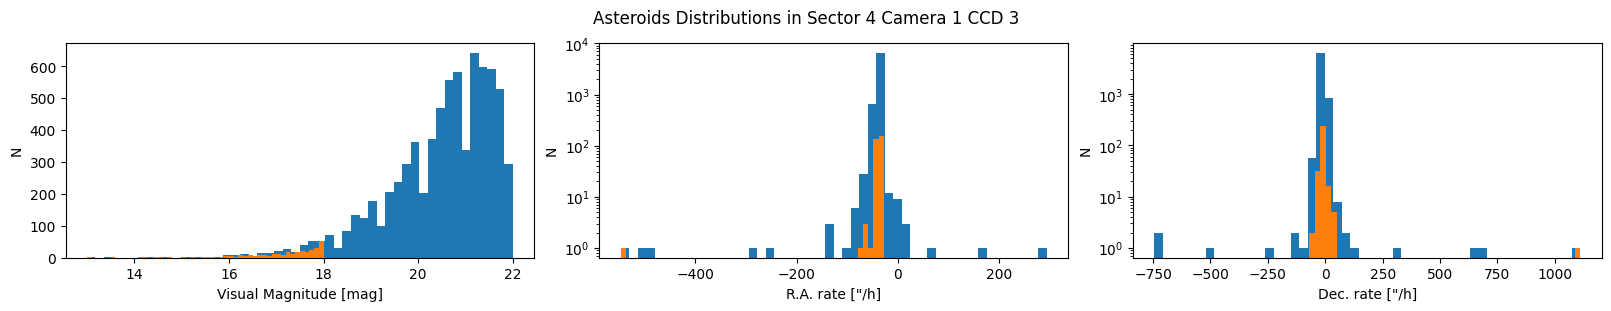

In [46]:
fig_dist, ax = plt.subplots(1, 3, figsize=(16, 3), constrained_layout=True)
fig_dist.suptitle(
    f"Asteroids Distributions in Sector {sector} Camera {camera} CCD {ccd}"
)
ax[0].hist(jpl_sb["V_mag"].values, bins=50)
ax[0].hist(jpl_sb_bright["V_mag"].values, bins=50)
ax[0].set_xlabel("Visual Magnitude [mag]")
ax[0].set_ylabel("N")
ax[1].hist(jpl_sb["RA rate (\"/h)"].values, bins=50, log=True)
ax[1].hist(jpl_sb_bright["RA rate (\"/h)"].values, bins=50, log=True)
ax[1].set_xlabel("R.A. rate [\"/h]")
ax[1].set_ylabel("N")
ax[2].hist(jpl_sb["Dec rate (\"/h)"].values, bins=50, log=True)
ax[2].hist(jpl_sb_bright["Dec rate (\"/h)"].values, bins=50, log=True)
ax[2].set_xlabel("Dec. rate [\"/h]")
ax[2].set_ylabel("N")
plt.show()

In [47]:
def in_cutout(cutout_col, cutout_row, asteroid_col, asteroid_row):
    is_in = ((asteroid_col >= cutout_col.min() - 2) & 
             (asteroid_col <= cutout_col.max() + 2) & 
             (asteroid_row >= cutout_row.min() - 2) & 
             (asteroid_row <= cutout_row.max() + 2))
    return is_in.any()

In [48]:
f"{ra_2d[1000, 900]:.4f} +{dec_2d[1000, 900]:.4f}"

'46.4056 +5.4682'

In [50]:
tpf = lk.search_tesscut(f"{ra_2d[1000, 900]:.4f} {dec_2d[1000, 900]:.4f}", 
                              sector=sector
                             ).download(cutout_size=(50, 50),
                                        quality_bitmask=None)

<Axes: title={'center': 'Target ID: 46.4056 5.4682, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

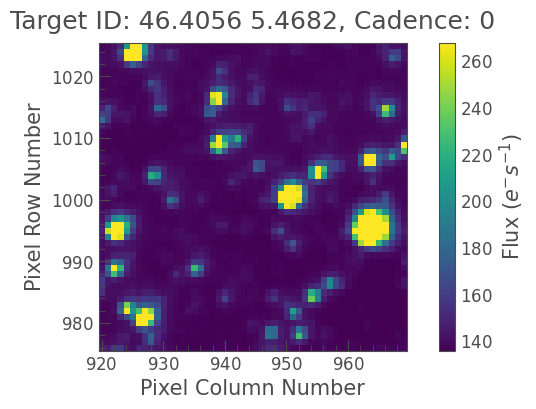

In [51]:
tpf.plot()

In [52]:
sb_ephems_lowres = {}

In [53]:
time_step = 100
jpl_sb_bright["query_name"] = None

for k, row in tqdm(jpl_sb_bright.iterrows(), total=len(jpl_sb_bright)):
    if k not in sb_ephems_lowres.keys():
        # query JPL to get asteroid track within sector times ever 12h
        try:
            te = TessEphem(row['id'], 
                            start=tpf.time[0], 
                            stop=tpf.time[-1], 
                            step="12H", 
                            id_type="smallbody",
                            )
            name_ok = row['id']
        except ValueError:
            te = TessEphem(row['name'], 
                           start=tpf.time[0], 
                           stop=tpf.time[-1], 
                           step="12H", 
                           id_type="smallbody",
                           )
            name_ok = row['name']
        # predict asteroid position in the sector with low res
        ephems_aux = te.predict(time=tpf.time[::time_step], 
                                aberrate=True, 
                                verbose=False,
                               )
        ephems_aux = ephems_aux.query(f"camera == {camera} and ccd == {ccd}")
        if len(ephems_aux) == 0:
            continue
        sb_ephems_lowres[k] = ephems_aux
        jpl_sb_bright.loc[k, "query_name"] = name_ok

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|███████████████████████████████████████████████████████████████████████████████| 297/297 [05:09<00:00,  1.04s/it]


In [ ]:
sb_ephems_lowres[8]

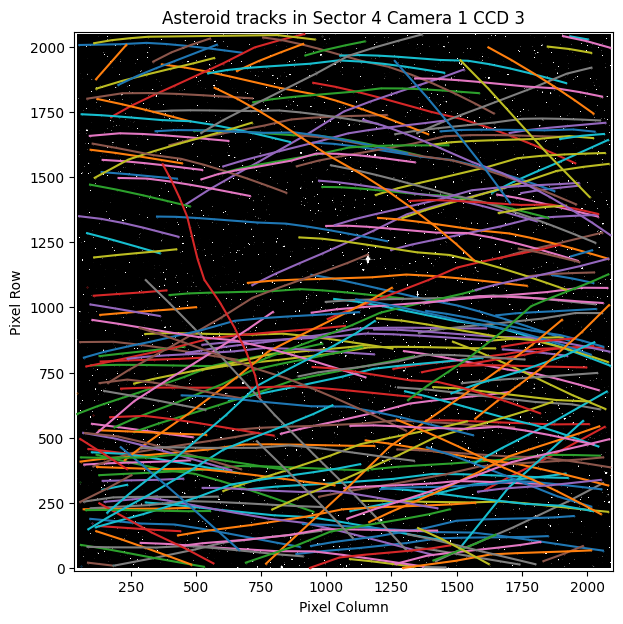

In [54]:
plt.figure(figsize=(7,7))
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD {ccd}")
# plt.scatter(col_2d, row_2d, s=1, c=f2d, vmin=500, vmax=5000)
plt.pcolormesh(col_2d, row_2d, f2d, vmin=400, vmax=2000, cmap="Greys_r")
# plt.scatter(fficut_aster.column, fficut_aster.row, s=1, label="TESScut", c="k")

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    plt.plot(val.column, val.row, ".-", ms=.5)
    # if k == 1: break

plt.xlim(col_2d.min() - 10, col_2d.max() + 10)
plt.ylim(row_2d.min() - 10, row_2d.max() + 10)
plt.gca().set_aspect('equal')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()

In [70]:
sampling = "tiled"

In [71]:
if sampling == "tiled":
    dx = 2
    xcen = np.arange(0 + dx, len(col_2d) - dx, 50)
    ycen = np.arange(0 + dx, len(row_2d) - dx, 50)
    xcen, ycen = np.meshgrid(xcen, ycen)
elif sampling == "random":
    ncuts = 20
    xcen, ycen = np.random.randint(0 + dx, len(col_2d) - dx, (2, ncuts))
    xcen, ycen = np.meshgrid(xcen, ycen)
else:
    raise NotImplementedError

<Axes: title={'center': 'Target ID: 69.8983 +15.8346, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

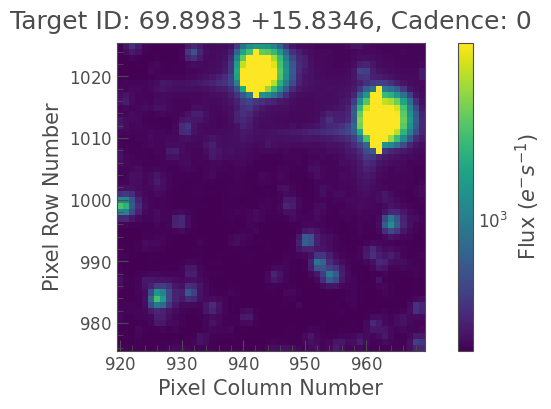

In [73]:
fficut_aster.tpf.plot(scale="log")

In [75]:
fficut_aster.get_CBVs(align=False, interpolate=True)

Extrapolation of CBVs appears to be necessary. Extrapolated values will be filled with zeros. Recommend setting extrapolate=True
Some interpolated (or extrapolated) CBV values have been set to zero


<Axes: title={'center': 'TESS CBVs (Sector.Camera.CCD : 43.3.3, CBVType.Band : MultiScale.2)'}, xlabel='Time [btjd]'>

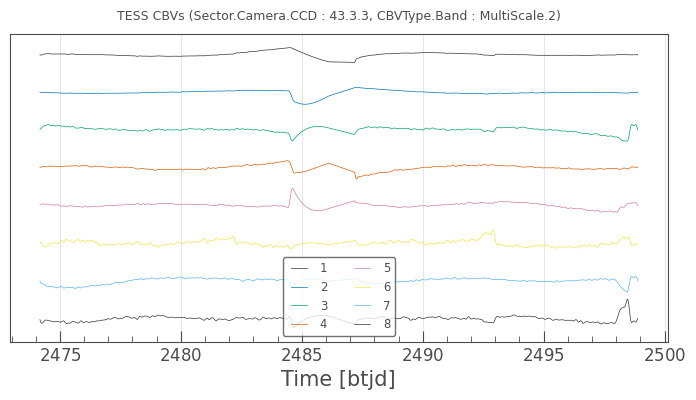

In [76]:
fficut_aster._cbvs.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

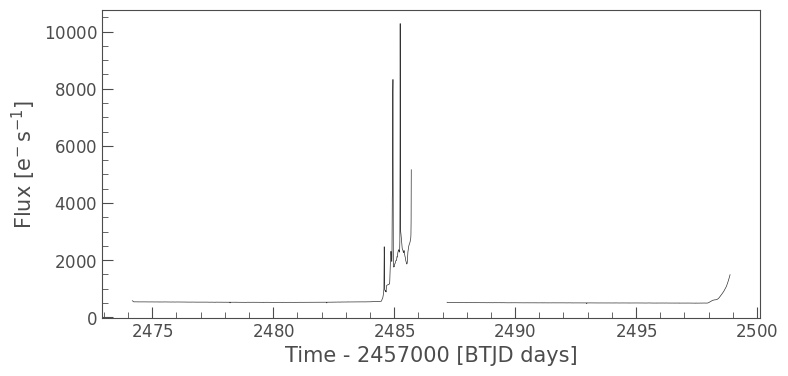

In [77]:
fficut_aster.tpf.to_lightcurve().plot()

In [31]:
sb_ephems_highres = {}

In [78]:
# del fficut_aster.asteroid_mask

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    # check if asteroid track passes over the TESScut
    is_in = in_cutout(fficut_aster.column, 
                      fficut_aster.row, 
                      sb_ephems_lowres[k].column.values, 
                      sb_ephems_lowres[k].row.values
                     )
    if is_in:
        print("Asteroid in cutout: ", jpl_sb_bright.loc[k, "query_name"])
        # predict full res track
        if k not in sb_ephems_highres.keys():
            te = TessEphem(jpl_sb_bright.loc[k, "query_name"], 
                               start=fficut_aster.tpf.time[0], 
                               stop=fficut_aster.tpf.time[-1], 
                               step="12H", 
                               id_type="smallbody",
                               )
            sb_ephems_highres[k] = te.predict(time=fficut_aster.tpf.time, 
                                              aberrate=True, 
                                              verbose=True,
                                             )
        source_rad =  2e2 / (sb_ephems_highres[k].vmag.mean()) ** 1.8
        print(source_rad)
        fficut_aster.get_asteroid_mask(sb_ephems_highres[k], 
                                       name=jpl_sb_bright.loc[k, "Object name"], 
                                       mask_type="circular", 
                                       mask_radius=source_rad
                                      )
    # if k == 2: break

Asteroid in cutout:  A801 AA
4.427394628574374


100%|██████████████████████████████████████████████████████████████████████████| 3408/3408 [00:00<00:00, 10192.25it/s]


Asteroid in cutout:  A865 SA
2.139284375427654


100%|██████████████████████████████████████████████████████████████████████████| 3408/3408 [00:00<00:00, 10507.81it/s]


In [79]:
fficut_aster.asteroid_names

{1: '1 Ceres (A801 AA)', 2: '85 Io (A865 SA)'}

In [80]:
fficut_aster.asteroid_time_idx

{1: array([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
        179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
        231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
        244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
        257, 258, 259, 260, 261, 262, 263, 264, 

In [81]:
time_idx = np.unique(np.hstack([x for x in fficut_aster.asteroid_time_idx.values()]))
time_idx

array([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 26

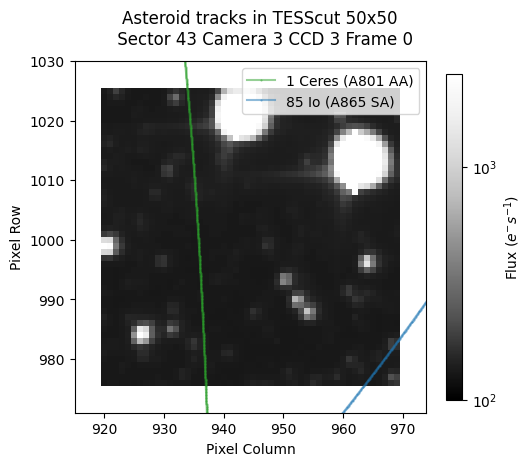

interactive(children=(IntSlider(value=83, description='frame', max=476, min=83, step=2), Output()), _dom_class…

In [82]:
frame = 0

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle(f"Asteroid tracks in TESScut 50x50 \n Sector {sector} Camera {camera} CCD {ccd} Frame {frame}", 
             y=0.95)
ima = ax.pcolormesh(fficut_aster.column_2d, 
                        fficut_aster.row_2d,
                        fficut_aster.flux_2d[frame],
                   cmap="Greys_r",
                   norm=colors.SymLogNorm(linthresh=1000, vmin=100, vmax=2500, base=10),
                   )
plt.colorbar(
    ima, ax=ax, label=r"Flux ($e^{-}s^{-1}$)", fraction=0.042
    )

aperture_mask = fficut_aster.asteroid_mask[frame].reshape(fficut_aster.cutout_size, fficut_aster.cutout_size)
for i in range(aperture_mask.shape[0]):
    for j in range(aperture_mask.shape[1]):
        if aperture_mask[i, j]:
            rect = patches.Rectangle(
                xy=(j + fficut_aster.column.min() - 0.5, i + fficut_aster.row.min() - 0.5),
                width=1,
                height=1,
                color="tab:red",
                fill=False,
                hatch="",
                alpha=.5
            )
            ax.add_patch(rect)

ax.plot(sb_ephems_highres[0].column, 
         sb_ephems_highres[0].row, 
         ".-", 
         ms=1,
         c="tab:green", alpha=.5,
         label=jpl_sb_bright.loc[0, "Object name"])
ax.plot(sb_ephems_highres[1].column, 
         sb_ephems_highres[1].row,
         ".-", 
         ms=1,
         c="tab:blue", alpha=.5,
         label=jpl_sb_bright.loc[1, "Object name"])

ax.set_xlim(fficut_aster.column.min() - 5,fficut_aster.column.max() + 5)
ax.set_ylim(fficut_aster.row.min() - 5,fficut_aster.row.max() + 5)
ax.set_aspect("equal")
ax.set_xlabel("Pixel Column")
ax.set_ylabel("Pixel Row")
ax.legend()


@widgets.interact(frame=(time_idx.min()-5, time_idx.max()+5, 2))
def update(frame=0):
    ax.pcolormesh(fficut_aster.column_2d, 
                  fficut_aster.row_2d,
                  fficut_aster.flux_2d[frame],
                   cmap="Greys_r",
                   norm=colors.SymLogNorm(linthresh=1000, vmin=100, vmax=2500, base=10),
                   )
    aperture_mask = fficut_aster.asteroid_mask[frame].reshape(fficut_aster.cutout_size, fficut_aster.cutout_size)
    for i in range(aperture_mask.shape[0]):
        for j in range(aperture_mask.shape[1]):
            if aperture_mask[i, j]:
                rect = patches.Rectangle(
                    xy=(j + fficut_aster.column.min() - 0.5, i + fficut_aster.row.min() - 0.5),
                    width=1,
                    height=1,
                    color="tab:red",
                    fill=False,
                    hatch="",
                    alpha=.5
                )
                ax.add_patch(rect)
    
    fig.suptitle(f"Asteroid tracks in TESScut 50x50 \n Sector {sector} Camera {camera} CCD {ccd} Frame {frame}", 
                y=0.95)
    return fig

plt.show()

In [239]:
fficut_aster.column_2d[:, 0]

array([920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932,
       933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945,
       946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958,
       959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969])

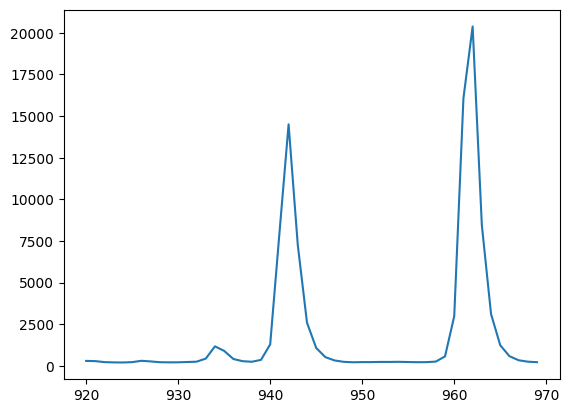

In [245]:
plt.plot(fficut_aster.column_2d[:, 0], fficut_aster.flux_2d[time_idx[50]].mean(axis=0));

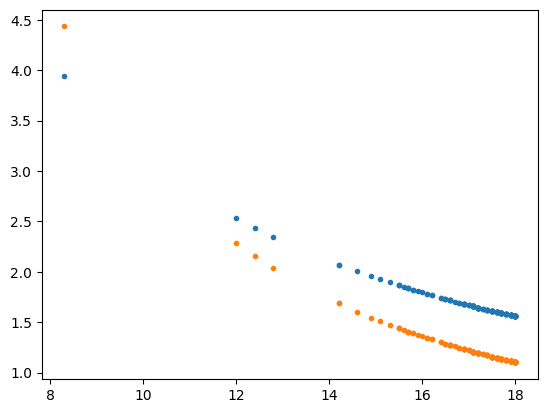

In [313]:
plt.plot(jpl_sb_bright.V_mag, 50 / (jpl_sb_bright.V_mag) ** 1.2, ".");
plt.plot(jpl_sb_bright.V_mag, 2e2 / (jpl_sb_bright.V_mag) ** 1.8, ".");

In [332]:
fficut_aster.asteroid_names.keys()

dict_keys([1, 2])

In [334]:
time_idx_s = {x: np.where((fficut_aster.asteroid_mask == x).any(axis=1))[0] for x in fficut_aster.asteroid_names.keys()}
time_idx_s

{1: array([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
        179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
        231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
        244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
        257, 258, 259, 260, 261, 262, 263, 264, 

In [ ]:
np.where(fficut_aster.asteroid_mask.sum(axis=1) > 0)

In [221]:
fficut_aster.save_data()

In [222]:
test = np.load("/Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/tess-cut_asteroid_data_s0043-3-3_69.9079_15.8276_50x50pix.npz", allow_pickle=True)
test

In [223]:
list(test.items())

[('flux',
  array([[206.92223, 208.8444 , 208.24284, ..., 211.10237, 212.01588,
          213.85443],
         [204.98814, 206.95428, 206.80899, ..., 208.8637 , 207.43503,
          213.0044 ],
         [204.57031, 205.50748, 205.24484, ..., 207.56711, 205.96227,
          208.77342],
         ...,
         [633.31305, 641.063  , 638.14703, ..., 645.01764, 644.3675 ,
          649.55865],
         [645.03876, 649.8139 , 648.04407, ..., 657.99115, 656.66864,
          657.4127 ],
         [659.5675 , 662.52954, 662.5574 , ..., 669.4917 , 667.5271 ,
          670.2137 ]], dtype=float32)),
 ('mask',
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 ('time',
  array([2459474.17155629, 2459474.17850143, 2459474.18544657, ...,
         2459498.8751023 , 2459498.88204726, 2459498.88899221])),
 ('cbvs',
  array([[-0.00139444

{'xobs': '1.21079e+05,3.09662e+05,-3.77501e+04,-5.12984e-01,6.22680e-01,1.74236e-01'}